#### 1. Refer to this section for a description of the problem

__[Kaggle](https://www.kaggle.com/competitions/titanic/data)__ platform provides two datasets (_train.csv_, _test.csv_) containing information about Titanic passengers, such as :

- An unique identifier for each passenger (_PassengerId_) ;
- The class of service in which the passenger traveled (_Pclass_) ;
- The passenger's full name (_Name_) ;
- The gender of the passenger (_Sex_) ;
- The age of the passenger (_Age_) ;
- The number of siblings or/and spouses with the passenger on the ship (_SibSp_) ;
- The number of parents or/and children with the passenger on the ship (_Parch_) ;
- The ticket number assigned to the passenger (_Ticket_) ;
- The fare paid by the passenger (_Fare_) ;
- The cabin number assigned to the passenger (_Cabin_) ;
- The port from which the passenger embarked (_Embarked_) ;
- The survival status of the passenger post-collision (_Survived_), which is available only for samples in _train.csv_.

Based on the data and relationships identified in the _train.csv_ file, we aim to predict the survival status of passengers listed in _test.csv_ file after the shipwreck.

#### 2. Import required libraries

In [129]:
import gc, pandas as pd, numpy as np, matplotlib.pyplot as plt, re
from scipy.stats import kruskal, chi2_contingency, spearmanr
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from scipy.optimize import minimize
from pathlib import Path

#### 3. Set up correct path

In [130]:
windowspath__scripts = Path().resolve()
windowspath__data = windowspath__scripts.parent / "data"

#### 4. Import train.csv and test.csv files

In [131]:
df__train = pd.read_csv(filepath_or_buffer=windowspath__data / "train" / "train.csv", dtype=str)
df__test = pd.read_csv(filepath_or_buffer=windowspath__data / "test" / "test.csv", dtype=str)

In [132]:
# Take a look at df__train
df__train.sample(n=3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
694,695,0,1,"Weir, Col. John",male,60,0,0,113800,26.55,NaN,S
656,657,0,3,"Radeff, Mr. Alexander",male,NaN,0,0,349223,7.8958,NaN,S
34,35,0,1,"Meyer, Mr. Edgar Joseph",male,28,1,0,PC 17604,82.1708,NaN,C


In [133]:
# Take a look at df__test
df__test.sample(n=3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
332,1224,3,"Thomas, Mr. Tannous",male,NaN,0,0,2684,7.225,NaN,C
306,1198,1,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S
328,1220,2,"Clarke, Mr. Charles Valentine",male,29,1,0,2003,26,NaN,S


Other than "Survived" (which we call target) and "PassengerId", all others features will be called covariates.

#### 5. Basic feature engineering (using some of the relations between covariates)

In [134]:
# Define an unified view of df__train and df__test
df__titanic = pd.concat([df__train.copy(deep=True).drop(columns=["Survived"]), df__test.copy(deep=True)], ignore_index=True)

# Do not forget that samples of df__train and df__test are identified by their PassengerId

# Take a look at df__titanic
df__titanic.sample(n=3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1088,1089,3,"Nilsson, Miss. Berta Olivia",female,18,0,0,347066,7.775,NaN,S
1274,1275,3,"McNamee, Mrs. Neal (Eileen O'Leary)",female,19,1,0,376566,16.1,NaN,S
694,695,1,"Weir, Col. John",male,60,0,0,113800,26.55,NaN,S


##### *5.1. PClass, Ticket, Cabin*

In [135]:
# Are there missing values in "Ticket" ?
df__titanic[["Ticket"]].isnull().sum()

Ticket    0
dtype: int64

In [136]:
# Are there missing values in "Cabin" ?
df__titanic[["Cabin"]].isnull().sum()

Cabin    1014
dtype: int64

In [137]:
# Are there missing values in "Pclass" ?
df__titanic[["Pclass"]].isnull().sum()

Pclass    0
dtype: int64

In [138]:
# Remove "Ticket" and "Cabin" since their information can be seen as summarized and grouped in "PClass"

# "Ticket" granularity could be a problem for a good model construction
# "Cabin" has missing values which would be difficult to impute, and even if we manage to impute them it has the same granularity problem as "Ticket"

df__titanic.drop(columns=["Ticket", "Cabin"], inplace=True)

In [139]:
# Rewrite "PClass" feature as "BoardingClass"
# first class is the most privileged, second class is moderately privileged, and third class is the least privileged. 
dict__pclass = {"1": "most privileged", "2": "moderately privileged", "3": "least privileged"}  
df__titanic["BoardingClass"] = df__titanic["Pclass"].map(dict__pclass)

# Cleanup
del df__titanic["Pclass"], dict__pclass

<Axes: title={'center': 'BoardingClass count distribution'}, xlabel='BoardingClass'>

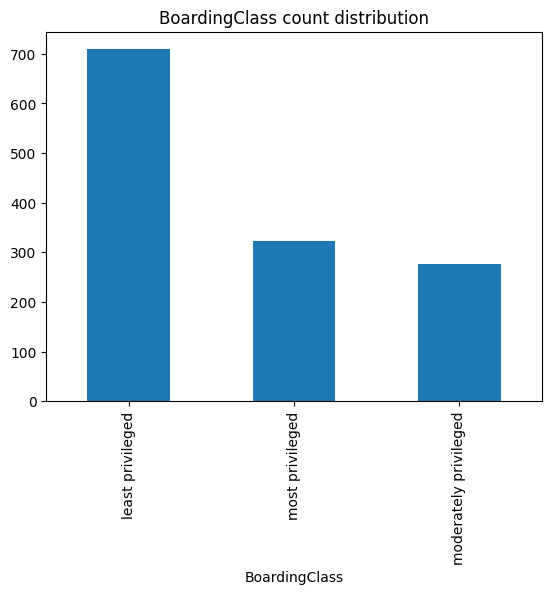

In [140]:
# Take a look at "BoardingClass"
df__titanic["BoardingClass"].value_counts().plot(kind="bar", title="BoardingClass count distribution")

<div style="background-color: green; padding: 10px;">
Half of the passengers on the ship are least privileged people.
</div>

In [141]:
# A view of df__titanic at this step
df__titanic.sample(n=3)

,PassengerId,Name,Sex,Age,SibSp,Parch,Fare,Embarked,BoardingClass
4,5,"Allen, Mr. William Henry",male,35,0,0,8.05,S,least privileged
1170,1171,"Oxenham, Mr. Percy Thomas",male,22,0,0,10.5,S,moderately privileged
264,265,"Henry, Miss. Delia",female,NaN,0,0,7.75,Q,least privileged


##### *5.2. Name, Sex, Age*

In [142]:
# Are there missing values in "Sex" ?
df__titanic[["Sex"]].isnull().sum()

Sex    0
dtype: int64

In [143]:
# Lowercase "Name" values, and remove periods
df__titanic["Name"] = df__titanic["Name"].apply(lambda x: x.lower().replace(".", ""))

<div style="background-color: green; padding: 10px;">

Research on early 20th-century naming conventions provides insights into titles incorporated in "Name" feature, which often indicated age or marital status :

- Adult titles : "mr", "mrs", "sir", "rev", "capt", "dr", "col", "major", "ms", "mme", "countess", "dona", "don", "jonkheer"

- Youth titles : "master", "miss"

- Ambiguous titles : "mlle" (used for both young girls and unmarried women)

Aldulthood for men was 21; whereas for women, it was 18 or 21.

</div>

In [144]:
df__titanic.sample(n=3)

,PassengerId,Name,Sex,Age,SibSp,Parch,Fare,Embarked,BoardingClass
946,947,"rice, master albert",male,10,4,1,29.125,Q,least privileged
154,155,"olsen, mr ole martin",male,NaN,0,0,7.3125,S,least privileged
232,233,"sjostedt, mr ernst adolf",male,59,0,0,13.5,S,moderately privileged


In [145]:
# Extract a "Title" column from "Name" column

# Define a list of all possible titles
list__adulttitles = ["mr", "mrs", "sir", "rev", "capt", "dr", "col", "major", "ms", "mme", "countess", "dona", "don", "jonkheer"] 
list__youngtitles = ["master", "miss"]
list__ambiguoustitles = ["mlle"]
list__alltitles = list__adulttitles + list__youngtitles + list__ambiguoustitles

# An example of function to extract title
def function__title(str__name: str) -> str:
    """
    Input:
    str__name : a string (real name and title)
    Output:
    str__title : a string (title)
    """

    # Create a regex pattern based on all possible titles
    str__pattern = r"\b(" + "|".join(map(re.escape, list__alltitles)) + r")\b"

    # Search the according pattern of str__pattern in str__name, and return the match
    return re.search(str__pattern, str__name).group(1)

# Apply function__title on "Name" column
df__titanic["Title"] = df__titanic["Name"].apply(lambda x: function__title(x))

# Cleanup
del df__titanic["Name"], list__alltitles

<Axes: title={'center': 'Title count distribution'}, xlabel='Title'>

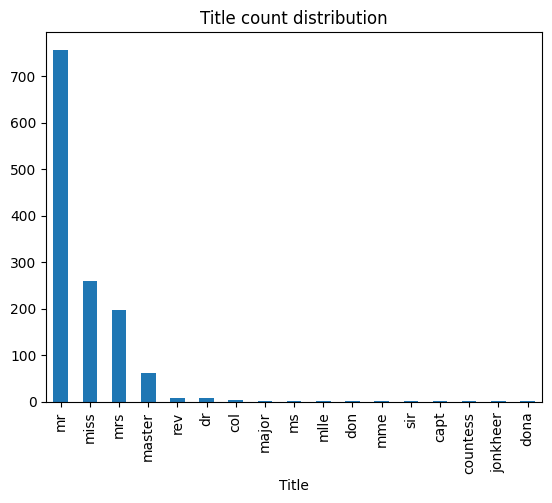

In [146]:
# Take a look at "Title"
df__titanic["Title"].value_counts().plot(kind="bar", title="Title count distribution")

<div style="background-color: green; padding: 10px;">
More than half of the passengers on the ship are adult men.
</div>

In [147]:
# Are there missing values in "Age" ?
df__titanic[["Age"]].isnull().sum()

Age    263
dtype: int64

In [148]:
# Set "Age" column data type to decimal number
df__titanic["Age"] = df__titanic["Age"].astype(float)

<div style="background-color: green; padding: 10px;">
Decimals age values can be challenging to interpret. Some of the folks who worked on Titanic problem, explained that these decimals arise when ages are estimated.
</div>

In [149]:
# Save "PassengerId" of those with "Age" decimal value, and missing "Age" value
list__missingage = list(set(df__titanic[(df__titanic["Age"].isnull() | (df__titanic["Age"] != np.ceil(df__titanic["Age"])))]["PassengerId"].tolist()))

In [150]:
# Analyze the proportion of samples with missing age values
print(f"Of the {len(df__titanic)} samples, {(100*df__titanic["Age"].isnull().sum() / len(df__titanic)):.2f}% have missing age values.")

Of the 1309 samples, 20.09% have missing age values.


In [151]:
# Define a new column "AgeCategory" based on "Title" and "Age"

# An example of function to categorize age
def function__agecategory(str__title: str, float__age: float, float__adulthood = 21.0) -> str:
    """
    Input:
    str__title : a string (title)
    float__age : a decimal number (age)
    float__adulthood : a decimal number (age value to know if adulthood is reached or not)
    Output:
    str__title : a string (title)
    """
    # Test if age value is not NaN
    if not np.isnan(float__age):
        # Compare its value to adulthood threshold
        return "young" if float__age < float__adulthood else "adult"
    
    # If age value is NaN, use title to determine category
    if str__title in list__adulttitles:
        return "adult"
    if str__title in list__youngtitles:
        return "young"
    if str__title in list__ambiguoustitles:
        return "young/adult"

# Apply function__agecategory
df__titanic["AgeCategory"] = df__titanic.apply(lambda row: function__agecategory(str__title=row["Title"], float__age=row["Age"]), axis=1)

# Cleanup
del df__titanic["Age"], df__titanic["Title"], list__adulttitles, list__youngtitles, list__ambiguoustitles

<Axes: title={'center': 'AgeCategory count distribution'}, xlabel='AgeCategory'>

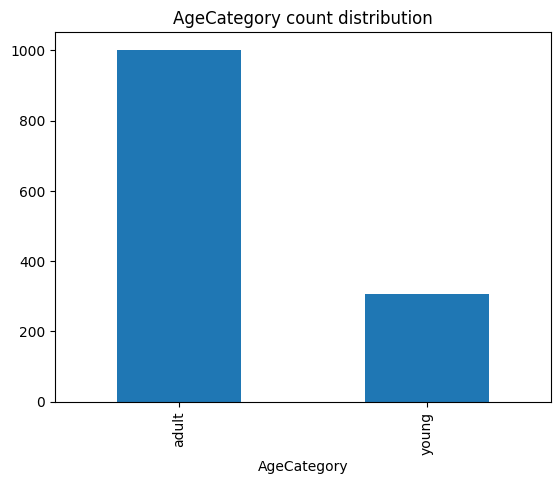

In [152]:
# Take a look at "AgeCategory"
df__titanic["AgeCategory"].value_counts().plot(kind="bar", title="AgeCategory count distribution")

<div style="background-color: green; padding: 10px;">
Since "AgeCategory" is a result of combining "Title" and "Age" in order to impute "Age" missing values, it's normal that more than half of the passengers are adults (especially adult men).
</div>

In [153]:
# A view of df__titanic at this step
df__titanic.sample(n=3)

,PassengerId,Sex,SibSp,Parch,Fare,Embarked,BoardingClass,AgeCategory
686,687,male,4,1,39.6875,S,least privileged,young
886,887,male,0,0,13,S,moderately privileged,adult
104,105,male,2,0,7.925,S,least privileged,adult


##### *5.3. SibSp, ParCh, Fare*

In [154]:
# Are there missing values in "SibSp"?
df__titanic[["SibSp"]].isnull().sum()

SibSp    0
dtype: int64

In [155]:
# Are there missing values in "Parch"?
df__titanic[["Parch"]].isnull().sum()

Parch    0
dtype: int64

In [156]:
# Set "SibSp" and "Parch" data type to integer
df__titanic[["SibSp","Parch"]] = df__titanic[["SibSp","Parch"]].astype(int)

# Create "FamilySize" by incrementing of 1 the sum of "SibSp" and "Parch" 
df__titanic["FamilySize"] = df__titanic[["SibSp","Parch"]].sum(axis=1) + 1

# Cleanup
df__titanic.drop(columns=["SibSp","Parch"], inplace=True)

<Axes: title={'center': 'FamilySize count distribution'}, xlabel='FamilySize'>

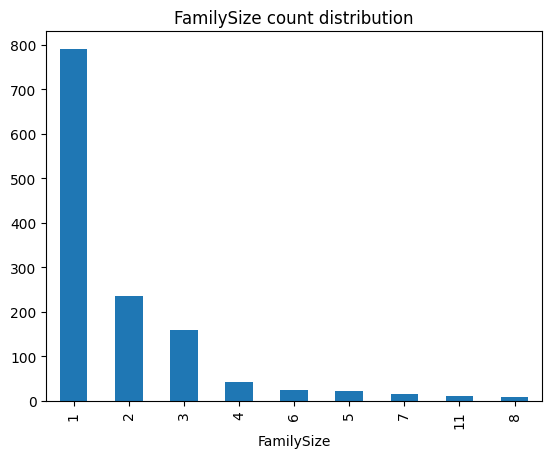

In [157]:
# Take a look at "FamilySize"
df__titanic["FamilySize"].value_counts().plot(kind="bar", title="FamilySize count distribution")

<div style="background-color: green; padding: 10px;">

More than half of the passengers on the ship were alone.

We decide to transform "FamilySize" into a qualitative variable with two modalities which are "alone" and "not alone".

</div>

In [158]:
# Transform "FamilySize" into a qualitative variable with two modalities : "alone" and "not alone"
df__titanic["FamilySize"] = df__titanic["FamilySize"].apply(lambda x: "alone" if x == 1 else "not alone")

In [159]:
# Are there missing values in "Fare" ?
df__titanic[["Fare"]].isnull().sum()

# Only one passenger "Fare" is missing.

Fare    1
dtype: int64

In [160]:
# Save "PassengerId" of those with "Fare" missing value
list__missingfare = df__titanic[df__titanic["Fare"].isnull()]["PassengerId"].tolist()

<Axes: title={'center': 'Fare distribution'}, ylabel='Frequency'>

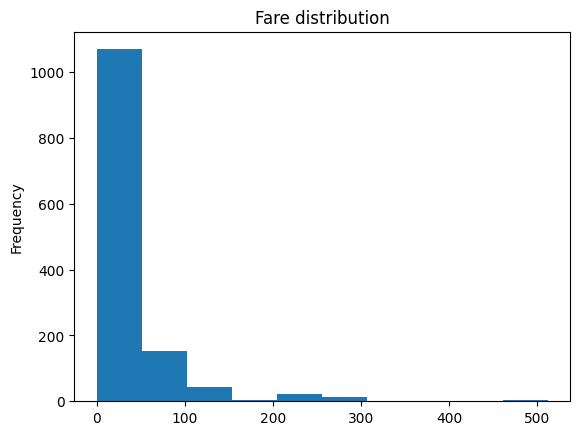

In [161]:
# Set "Fare" data type to float
df__titanic["Fare"] = df__titanic["Fare"].astype(float)

# Take a look at "Fare"
df__titanic["Fare"].plot(kind="hist", title="Fare distribution")

<div style="background-color: green; padding: 10px;">
"Fare" distribution is right-skewed, which is normal since most of the people were least priviliged (3rd class tickets).
Let's dive further.
</div>

In [162]:
# Cross "Fare" values with "BoardingClass" modalities
# Don't forget to here use only training data

df__titanic[df__titanic["PassengerId"].isin(df__train["PassengerId"].tolist())].groupby(["BoardingClass"], observed=False).describe()

Fare                                                \
                       count       mean        std  min       25%      50%   
BoardingClass                                                                
least privileged       491.0  13.675550  11.778142  0.0   7.75000   8.0500   
moderately privileged  184.0  20.662183  13.417399  0.0  13.00000  14.2500   
most privileged        216.0  84.154687  78.380373  0.0  30.92395  60.2875   

                                       
                        75%       max  
BoardingClass                          
least privileged       15.5   69.5500  
moderately privileged  26.0   73.5000  
most privileged        93.5  512.3292

<div style="background-color: green; padding: 10px;">
Tickets "Fare" seem to depend on the "BoardingClass" : its value is the highest in the most privileged "BoardingClass". 
 
Let's confirm statistically the correlation between these two features.
</div>

In [163]:
# Do a Kruskall-Wallis test between "Fare" and "BoardingClass" as a proof of high correlation between these two features
# Don't forget to here use only training data

# Do not consider the passenger with missing "Fare", and remove duplicates
df__table = df__titanic[df__titanic["PassengerId"].isin(df__train["PassengerId"].tolist())][["Fare", "BoardingClass"]].copy(deep=True).dropna().drop_duplicates()

# Perform a Kruskall-Wallis test of a 5% risk level
kruskal(*df__table.groupby(["BoardingClass"], observed=False)["Fare"].apply(list))

KruskalResult(statistic=np.float64(154.00589915116032), pvalue=np.float64(3.614464045876876e-34))

In [164]:
# Compute the spearman correlation between "Fare" and "BoardingClass" using df__table

# Transform "BoardingClass" modalities in df__table such as : 
# "least privileged" = 1, "moderately privileged" = 2, and "most privileged" = 3
df__table["BoardingClass"] = df__table["BoardingClass"].apply(lambda x: 1 if x == "least privileged" else 2 if x == "moderately privileged" else 3)

# Compute the spearman correlation
spearmanr(df__table["BoardingClass"], df__table["Fare"])

SignificanceResult(statistic=np.float64(0.7730586879698828), pvalue=np.float64(6.268128949654468e-52))

<div style="background-color: green; padding: 10px;">

Based on the 891 passengers of _train.csv_ having no missing "Fare" value :
- The p-value computed from a Kruskal-Wallis test between "Fare" and "BoardingClass" is up to 3.61e-34 (lesser than 0.05);
- The spearman correlation value between these features is up to 0.77.
- We conclude that statistically there's enough proof of correlation between "BoardingClass" and "Fare" under a 5% risk level.

Since "Fare" is the one with one missing value out of 1309 passengers (value especially missing for a sample in _test.csv_), we'll remove it and keep only "BoardingClass".
</div>

In [165]:
# Cleanup
del df__table, df__titanic["Fare"]

In [166]:
# A view of df__titanic at this step
df__titanic.sample(n=3)

,PassengerId,Sex,Embarked,BoardingClass,AgeCategory,FamilySize
679,680,male,C,most privileged,adult,not alone
558,559,female,S,most privileged,adult,not alone
1094,1095,female,S,moderately privileged,young,not alone


##### *5.4. Embarked*

In [167]:
# Are there missing values in "Embarked" ?
df__titanic[["Embarked"]].isnull().sum()

# Two passengers' embarkation towns are missing.

Embarked    2
dtype: int64

In [168]:
# Save "PassengerId" of those with "Embarked" missing value
list__missingembarked = df__titanic[df__titanic["Embarked"].isnull()]["PassengerId"].tolist()

<Axes: title={'center': 'Embarked count distribution'}, xlabel='Embarked'>

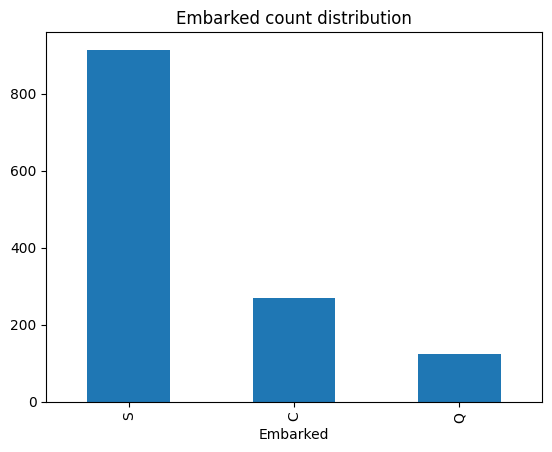

In [169]:
# Take a look at "Embarked"
df__titanic["Embarked"].value_counts().plot(kind="bar", title="Embarked count distribution")

<div style="background-color: green; padding: 10px;">
More than half of the passengers on the ship were embarked from Southampton (S).
</div>

In [170]:
# We choose to impute the most present modality to these two passengers with missing embarkation towns
df__titanic["Embarked"] = df__titanic["Embarked"].fillna(value=df__titanic["Embarked"].mode()[0], inplace=False)

In [171]:
# A view of df__titanic at this step
df__titanic.sample(n=3)

,PassengerId,Sex,Embarked,BoardingClass,AgeCategory,FamilySize
1227,1228,male,S,moderately privileged,adult,alone
237,238,female,S,moderately privileged,young,not alone
911,912,male,C,most privileged,adult,not alone


In [172]:
# Take a look at df__titanic size
df__titanic.shape

(1309, 6)

##### *5.5. Retrieve engineered versions of df__train and df__test*

In [173]:
# Get engineered version of df__train
df__engineeredtrain = df__train[["PassengerId", "Survived"]].merge(right=df__titanic, on=["PassengerId"], how="left")

# Get engineered version of df__test
df__engineeredtest = df__test[["PassengerId"]].merge(right=df__titanic, on=["PassengerId"], how="left")

# Cleanup
del df__titanic

In [174]:
# Make sure joins and feature engineering worked well so no missing values are present in df__engtrain
df__engineeredtrain.isnull().sum()

PassengerId      0
Survived         0
Sex              0
Embarked         0
BoardingClass    0
AgeCategory      0
FamilySize       0
dtype: int64

In [175]:
# Get all groups of identic PassengerId in characteristics
df__engineeredtrain['SimilarPassengerIds'] = df__engineeredtrain.groupby(df__engineeredtrain.columns[~(df__engineeredtrain.columns.isin(["PassengerId"]))].tolist())['PassengerId'].transform(lambda x: '__'.join(x))

In [176]:
# Remove "PassengerId" column, then remove duplicate rows
del df__engineeredtrain["PassengerId"]
df__engineeredtrain.drop_duplicates(inplace=True)

# Reset index values
df__engineeredtrain.reset_index(inplace=True,drop=True)

In [177]:
# Take a look at df__engineeredtrain size
df__engineeredtrain.shape

(94, 7)

In [178]:
# Make sure joins and feature engineering worked well so no missing values are present in df__engtest
df__engineeredtest.isnull().sum()

PassengerId      0
Sex              0
Embarked         0
BoardingClass    0
AgeCategory      0
FamilySize       0
dtype: int64

In [179]:
# Empty garbage collector
gc.collect()

102

#### 6. Advanced feature engineering (using all possible relations between covariates and the target Survived)

##### *6.1. Sex and Survived*

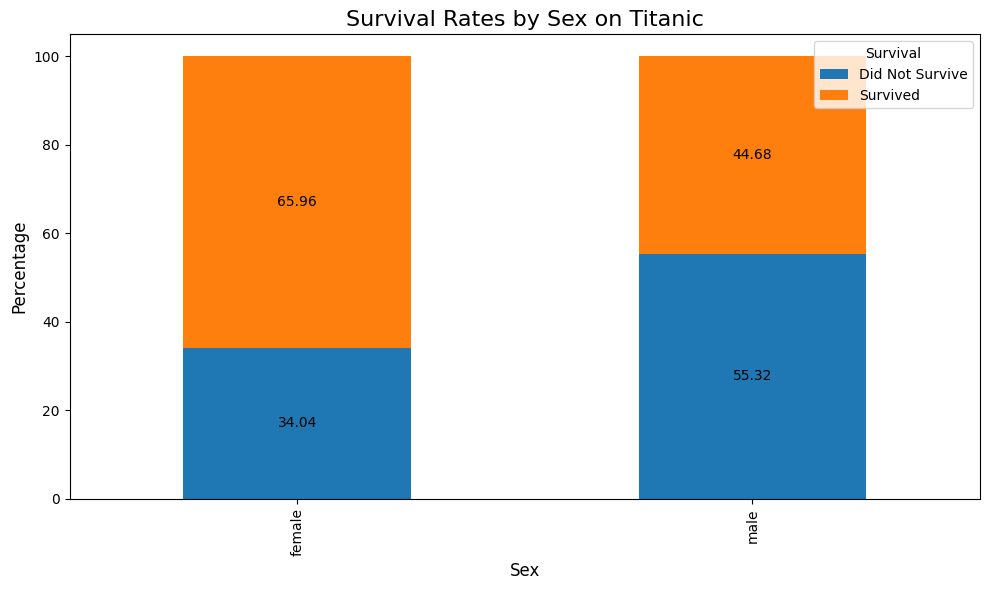

In [180]:
# Create a cross-tab between "Sex" and "Survived"
df__table = 100 * pd.crosstab(df__engineeredtrain["Sex"], df__engineeredtrain["Survived"], normalize="index")

# Create the stacked bar chart
ax__object = df__table.plot(kind="bar", stacked=True, figsize=(10, 6))

# Customize the chart
plt.title("Survival Rates by Sex on Titanic", fontsize=16)
plt.xlabel("Sex", fontsize=12)
plt.ylabel("Percentage", fontsize=12)
plt.legend(["Did Not Survive", "Survived"], title="Survival", loc="upper right")

# Add value labels on the bars, rounded to two decimal places
for barcontainer__object in ax__object.containers:
    ax__object.bar_label(barcontainer__object, label_type="center", fmt="%.2f")

# Adjust layout and display
plt.tight_layout()
plt.show()

In [181]:
# Cleanup
del df__table, ax__object, barcontainer__object

In [182]:
# Perform a Chi-Square test (risk level of 5%) between "Sex" and "Survived"
chi2_contingency(pd.crosstab(df__engineeredtrain["Sex"], df__engineeredtrain["Survived"]))

Chi2ContingencyResult(statistic=np.float64(3.4862637362637363), pvalue=np.float64(0.061880097362495085), dof=1, expected_freq=array([[21., 26.],
       [21., 26.]]))

In [183]:
# Calculate Cramer's V : strength of the association between "Sex" and "Survived"
df__table = pd.crosstab(df__engineeredtrain["Sex"], df__engineeredtrain["Survived"])
np.sqrt(chi2_contingency(df__table)[0] / (df__table.sum().sum() * (min(df__table.shape) - 1)))

np.float64(0.19258222162991082)

In [184]:
# Cleanup
del df__table

<div style="background-color: green; padding: 10px;">

- The p-value of the Chi-Square test between "Sex" and "Survived" is up to 0.06 (a little higher than 0.05).

- The strength of the association between "Sex" and "Survived" is only up to 19.26%.

- For a risk level of 5%, **there's not enough proof based only on 94 samples** to attest that the survival rate of a passenger on the Titanic is statistically linked to him being a man/woman; but, since their strength of association can be seen as moderate we won't be discarding immediately this feature.

</div>

##### *6.2. Embarked and Survived*

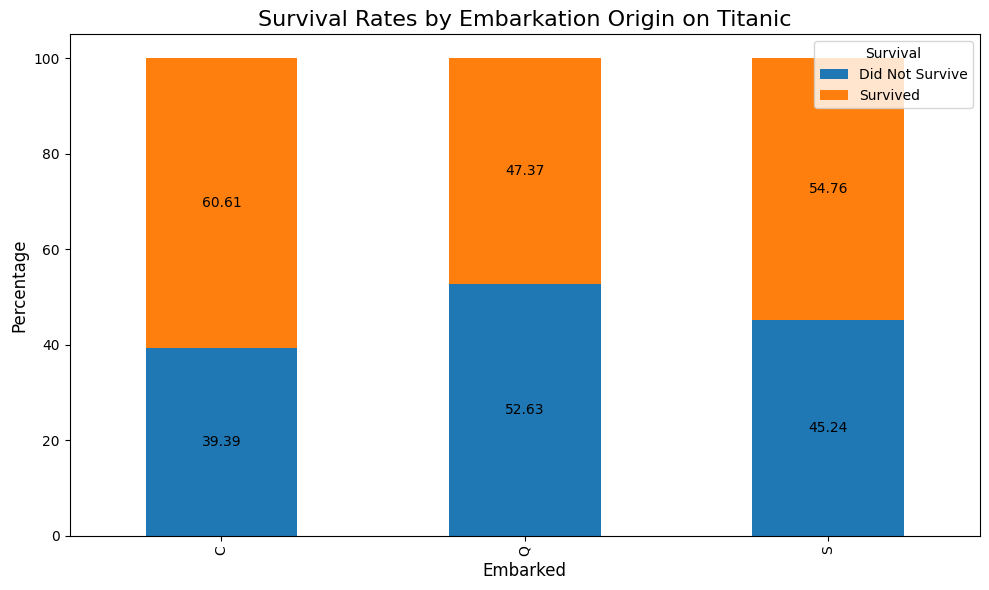

In [185]:
# Create a cross-tab between "Embarked" and "Survived"
df__table = 100 * pd.crosstab(df__engineeredtrain["Embarked"], df__engineeredtrain["Survived"], normalize="index")

# Create the stacked bar chart
ax__object = df__table.plot(kind="bar", stacked=True, figsize=(10, 6))

# Customize the chart
plt.title("Survival Rates by Embarkation Origin on Titanic", fontsize=16)
plt.xlabel("Embarked", fontsize=12)
plt.ylabel("Percentage", fontsize=12)
plt.legend(["Did Not Survive", "Survived"], title="Survival", loc="upper right")

# Add value labels on the bars, rounded to two decimal places
for barcontainer__object in ax__object.containers:
    ax__object.bar_label(barcontainer__object, label_type="center", fmt="%.2f")

# Adjust layout and display
plt.tight_layout()
plt.show()

In [186]:
# Cleanup
del df__table, ax__object, barcontainer__object

In [187]:
# Perform a Chi-Square test (risk level of 5%) between "Embarked" and "Survived"
chi2_contingency(pd.crosstab(df__engineeredtrain["Embarked"], df__engineeredtrain["Survived"]))

Chi2ContingencyResult(statistic=np.float64(0.8643851970919639), pvalue=np.float64(0.6490843519433382), dof=2, expected_freq=array([[14.74468085, 18.25531915],
       [ 8.4893617 , 10.5106383 ],
       [18.76595745, 23.23404255]]))

In [188]:
# Calculate Cramer's V : strength of the association between "Embarked" and "Survived"
df__table = pd.crosstab(df__engineeredtrain["Embarked"], df__engineeredtrain["Survived"])
np.sqrt(chi2_contingency(df__table)[0] / (df__table.sum().sum() * (min(df__table.shape) - 1)))

np.float64(0.09589362441323197)

In [189]:
# Cleanup
del df__table

<div style="background-color: green; padding: 10px;">

- The p-value of the Chi-Square test between "Embarked" and "Survived" is up to 0.65 (higher than 0.05).

- The strength of the association between "Embarked" and "Survived" is only up to 9.59%.

- For a risk level of 5%, **there's not enough proof based only on 94 samples** to attest that the survival rate of a passenger on the Titanic is statistically linked to his embarkation point; but, since their strength of association can be seen as moderate we won't be discarding immediately this feature.

</div>

##### *6.3. BoardingClass and Survived*

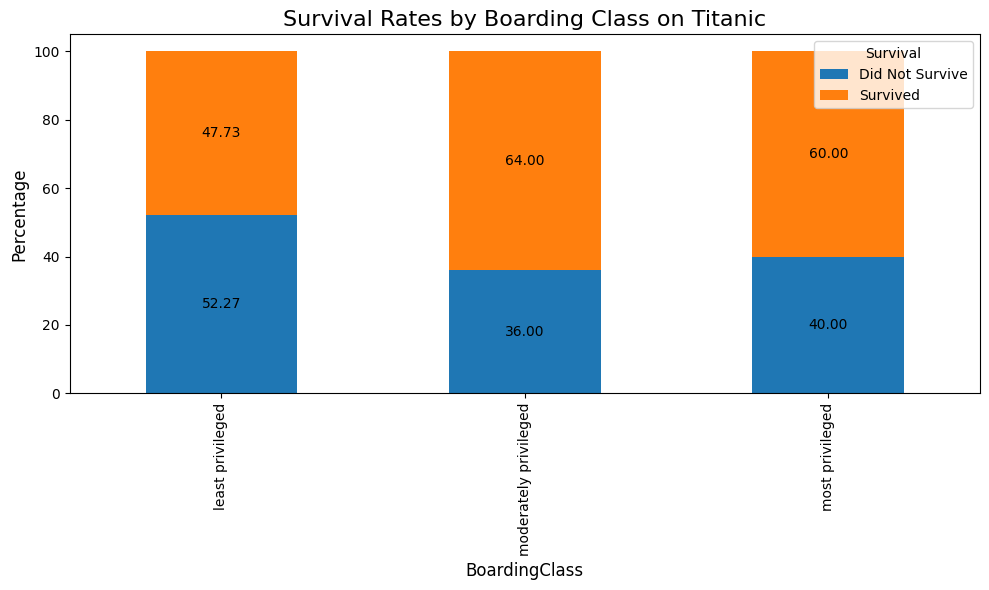

In [190]:
# Create a cross-tab between "BoardingClass" and "Survived"
df__table = 100 * pd.crosstab(df__engineeredtrain["BoardingClass"], df__engineeredtrain["Survived"], normalize="index")

# Create the stacked bar chart
ax__object = df__table.plot(kind="bar", stacked=True, figsize=(10, 6))

# Customize the chart
plt.title("Survival Rates by Boarding Class on Titanic", fontsize=16)
plt.xlabel("BoardingClass", fontsize=12)
plt.ylabel("Percentage", fontsize=12)
plt.legend(["Did Not Survive", "Survived"], title="Survival", loc="upper right")

# Add value labels on the bars, rounded to two decimal places
for barcontainer__object in ax__object.containers:
    ax__object.bar_label(barcontainer__object, label_type="center", fmt="%.2f")

# Adjust layout and display
plt.tight_layout()
plt.show()

In [191]:
# Cleanup
del df__table, ax__object, barcontainer__object

In [192]:
# Perform a Chi-Square test (risk level of 5%) between "BoardingClass" and "Survived"
chi2_contingency(pd.crosstab(df__engineeredtrain["BoardingClass"], df__engineeredtrain["Survived"]))

Chi2ContingencyResult(statistic=np.float64(2.009825174825173), pvalue=np.float64(0.3660766331111594), dof=2, expected_freq=array([[19.65957447, 24.34042553],
       [11.17021277, 13.82978723],
       [11.17021277, 13.82978723]]))

In [193]:
# Calculate Cramer's V : strength of the association between "BoardingClass" and "Survived"
df__table = pd.crosstab(df__engineeredtrain["BoardingClass"], df__engineeredtrain["Survived"])
np.sqrt(chi2_contingency(df__table)[0] / (df__table.sum().sum() * (min(df__table.shape) - 1)))

np.float64(0.1462228398066419)

In [194]:
# Cleanup
del df__table

<div style="background-color: green; padding: 10px;">

- The p-value of the Chi-Square test between "BoardingClass" and "Survived" is up to 0.37 (higher than 0.05).

- The strength of the association between "BoardingClass" and "Survived" is only up to 14.62%.

- For a risk level of 5%, **there's not enough proof based only on 94 samples** to attest that the survival rate of a passenger on the Titanic is statistically linked to his boarding class; but, since their strength of association can be seen as moderate we won't be discarding immediately this feature.

</div>

##### *6.4. AgeCategory and Survived*

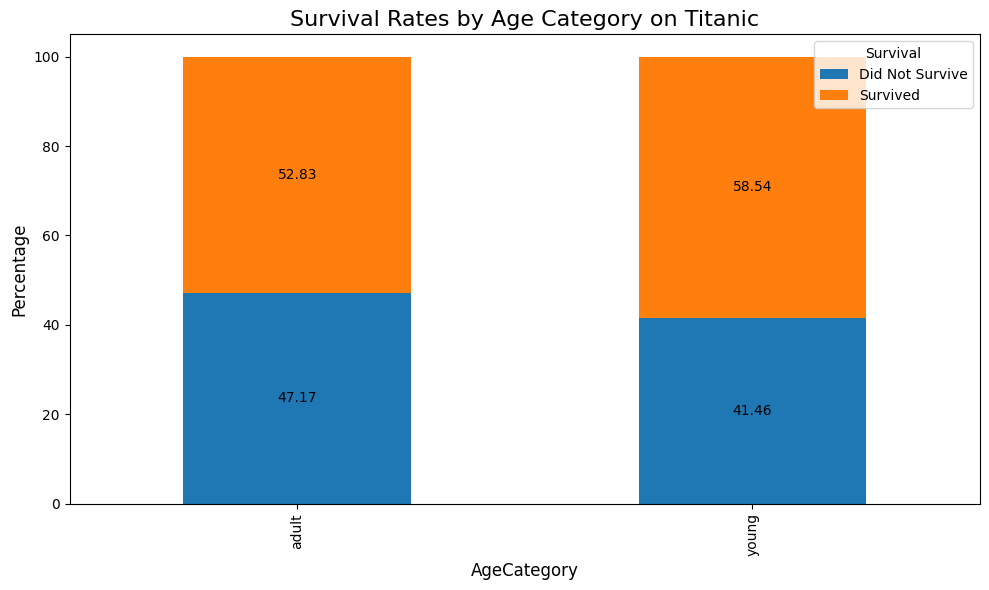

In [195]:
# Create a cross-tab between "AgeCategory" and "Survived"
df__table = 100 * pd.crosstab(df__engineeredtrain["AgeCategory"], df__engineeredtrain["Survived"], normalize="index")

# Create the stacked bar chart
ax__object = df__table.plot(kind="bar", stacked=True, figsize=(10, 6))

# Customize the chart
plt.title("Survival Rates by Age Category on Titanic", fontsize=16)
plt.xlabel("AgeCategory", fontsize=12)
plt.ylabel("Percentage", fontsize=12)
plt.legend(["Did Not Survive", "Survived"], title="Survival", loc="upper right")

# Add value labels on the bars, rounded to two decimal places
for barcontainer__object in ax__object.containers:
    ax__object.bar_label(barcontainer__object, label_type="center", fmt="%.2f")

# Adjust layout and display
plt.tight_layout()
plt.show()

In [196]:
# Cleanup
del df__table, ax__object, barcontainer__object

In [197]:
# Perform a Chi-Square test (risk level of 5%) between "AgeCategory" and "Survived"
chi2_contingency(pd.crosstab(df__engineeredtrain["AgeCategory"], df__engineeredtrain["Survived"]))

Chi2ContingencyResult(statistic=np.float64(0.11743483545140213), pvalue=np.float64(0.7318334436765885), dof=1, expected_freq=array([[23.68085106, 29.31914894],
       [18.31914894, 22.68085106]]))

In [198]:
# Calculate Cramer's V : strength of the association between "AgeCategory" and "Survived"
df__table = pd.crosstab(df__engineeredtrain["AgeCategory"], df__engineeredtrain["Survived"])
np.sqrt(chi2_contingency(df__table)[0] / (df__table.sum().sum() * (min(df__table.shape) - 1)))

np.float64(0.03534553380727612)

In [199]:
# Cleanup
del df__table

<div style="background-color: green; padding: 10px;">

- The p-value of the Chi-Square test between "AgeCategory" and "Survived" is up to 0.73 (higher than 0.05).

- The strength of the association between "AgeCategory" and "Survived" is up to 3.53%.

- For a risk level of 5%, **there's no enough proof based only on 94 samples** to attest that the survival rate of a passenger on the Titanic is statistically linked to him being young or adult; even if in this case as we can see their strength of association is really low, we won't be discarding immediately this feature but he'll be among first choices later when trying to improve a model.

</div>

##### *6.5. FamilySize and Survived*

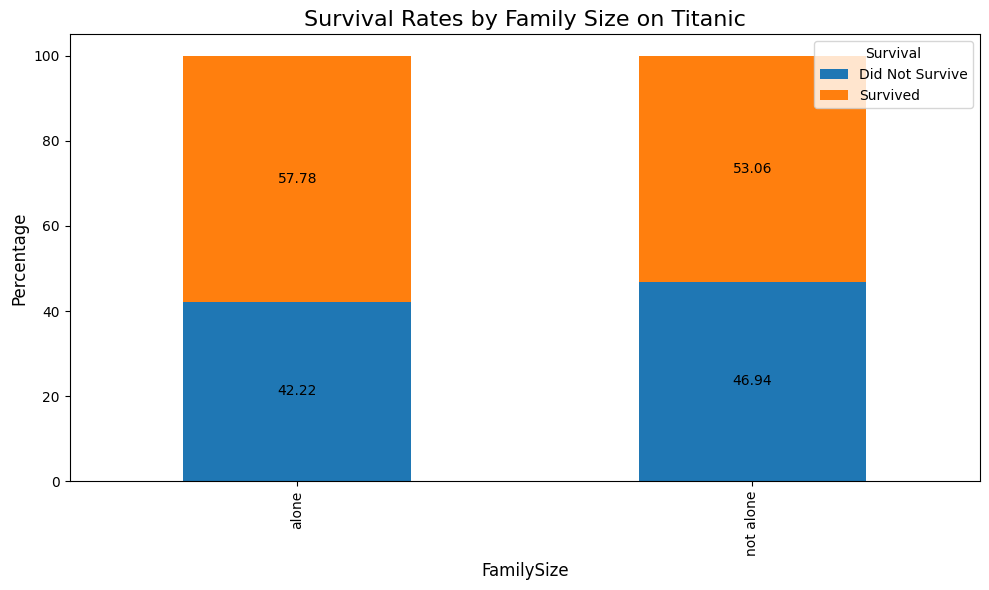

In [200]:
# Create a cross-tab between "FamilySize" and "Survived"
df__table = 100 * pd.crosstab(df__engineeredtrain["FamilySize"], df__engineeredtrain["Survived"], normalize="index")

# Create the stacked bar chart
ax__object = df__table.plot(kind="bar", stacked=True, figsize=(10, 6))

# Customize the chart
plt.title("Survival Rates by Family Size on Titanic", fontsize=16)
plt.xlabel("FamilySize", fontsize=12)
plt.ylabel("Percentage", fontsize=12)
plt.legend(["Did Not Survive", "Survived"], title="Survival", loc="upper right")

# Add value labels on the bars, rounded to two decimal places
for barcontainer__object in ax__object.containers:
    ax__object.bar_label(barcontainer__object, label_type="center", fmt="%.2f")

# Adjust layout and display
plt.tight_layout()
plt.show()

In [201]:
# Cleanup
del df__table, ax__object, barcontainer__object

In [202]:
# Perform a Chi-Square test (risk level of 5%) between "FamilySize" and "Survived"
chi2_contingency(pd.crosstab(df__engineeredtrain["FamilySize"], df__engineeredtrain["Survived"]))

Chi2ContingencyResult(statistic=np.float64(0.06341855423488046), pvalue=np.float64(0.8011721526621649), dof=1, expected_freq=array([[20.10638298, 24.89361702],
       [21.89361702, 27.10638298]]))

In [203]:
# Calculate Cramer's V : strength of the association between "FamilySize" and "Survived"
df__table = pd.crosstab(df__engineeredtrain["FamilySize"], df__engineeredtrain["Survived"])
np.sqrt(chi2_contingency(df__table)[0] / (df__table.sum().sum() * (min(df__table.shape) - 1)))

np.float64(0.02597432329405012)

In [204]:
# Cleanup
del df__table

<div style="background-color: green; padding: 10px;">

- The p-value of the Chi-Square test between "FamilySize" and "Survived" is up to 0.8 (higher than 0.05).

- The strength of the association between "FamilySize" and "Survived" is estimated at 2.6%.

- For a risk level of 5%, **there's no enough proof based only on 94 samples** to attest that the survival rate of a passenger on the Titanic is statistically linked to his family size; ; even if in this case as we can see their strength of association is really low, we won't be discarding immediately this feature but he'll be among first choices later when trying to improve a model.

</div>

##### *6.6. Make sure correlations between covariates are low*

In [205]:
# Cross-tab between "Sex" and "Embarked"
df__table = pd.crosstab(df__engineeredtrain["Sex"], df__engineeredtrain["Embarked"])

# Perform a Chi-Square test (risk level of 5%) between "Sex" and "Embarked"
print(f"The p-value is {chi2_contingency(df__table)[1]:.2f}")

# Calculate Cramer's V : strength of the association between "Sex" and "Embarked"
print(f"The strength of the association is {np.sqrt(chi2_contingency(df__table)[0] / (df__table.sum().sum() * (min(df__table.shape) - 1))):.2f}")

# Cleanup
del df__table

The p-value is 0.74
The strength of the association is 0.08


<div style="background-color: green; padding: 10px;">
Statistically, based on these 94 samples we can assume there's no strong correlation between "Sex" and "Embarked" for a 5% risk level.
</div>

In [206]:
# Cross-tab between "Sex" and "BoardingClass"
df__table = pd.crosstab(df__engineeredtrain["Sex"], df__engineeredtrain["BoardingClass"])

# Perform a Chi-Square test (risk level of 5%) between "Sex" and "BoardingClass"
print(f"The p-value is {chi2_contingency(df__table)[1]:.2f}")

# Calculate Cramer's V for effect size : strength of the association between "Sex" and "BoardingClass"
print(f"The strength of the association is {np.sqrt(chi2_contingency(df__table)[0] / (df__table.sum().sum() * (min(df__table.shape) - 1))):.2f}")

# Cleanup
del df__table

The p-value is 0.92
The strength of the association is 0.04


<div style="background-color: green; padding: 10px;">
Statistically, based on these 94 samples we can assume there's no strong correlation between "Sex" and "BoardingClass" for a 5% risk level.
</div>

In [207]:
# Cross-tab between "Sex" and "AgeCategory"
df__table = pd.crosstab(df__engineeredtrain["Sex"], df__engineeredtrain["AgeCategory"])

# Perform a Chi-Square test (risk level of 5%) between "Sex" and "AgeCategory"
print(f"The p-value is {chi2_contingency(df__table)[1]:.2f}")

# Calculate Cramer's V for effect size : strength of the association between "Sex" and "AgeCategory"
print(f"The strength of the association is {np.sqrt(chi2_contingency(df__table)[0] / (df__table.sum().sum() * (min(df__table.shape) - 1))):.2f}")

# Cleanup
del df__table

The p-value is 0.68
The strength of the association is 0.04


<div style="background-color: green; padding: 10px;">
Statistically, based on these 94 samples we can assume there's no strong correlation between "Sex" and "AgeCategory" for a 5% risk level.
</div>

In [208]:
# Cross-tab between "Sex" and "FamilySize"
df__table = pd.crosstab(df__engineeredtrain["Sex"], df__engineeredtrain["FamilySize"])

# Perform a Chi-Square test (risk level of 5%) between "Sex" and "FamilySize"
print(f"The p-value is {chi2_contingency(df__table)[1]:.2f}")

# Calculate Cramer's V for effect size : strength of the association between "Sex" and "FamilySize"
print(f"The strength of the association is {np.sqrt(chi2_contingency(df__table)[0] / (df__table.sum().sum() * (min(df__table.shape) - 1))):.2f}")

# Cleanup
del df__table

The p-value is 1.00
The strength of the association is 0.00


<div style="background-color: green; padding: 10px;">
Statistically, based on these 94 samples we can assume there's no strong correlation between "Sex" and "FamilySize" for a 5% risk level.
</div>

In [209]:
# Cross-tab between "Embarked" and "BoardingClass"
df__table = pd.crosstab(df__engineeredtrain["Embarked"], df__engineeredtrain["BoardingClass"])

# Perform a Chi-Square test (risk level of 5%) between "Embarked" and "BoardingClass"
print(f"The p-value is {chi2_contingency(df__table)[1]:.2f}")

# Calculate Cramer's V for effect size : strength of the association between "Embarked" and "BoardingClass"
print(f"The strength of the association is {np.sqrt(chi2_contingency(df__table)[0] / (df__table.sum().sum() * (min(df__table.shape) - 1))):.2f}")

# Cleanup
del df__table

The p-value is 0.10
The strength of the association is 0.20


<div style="background-color: green; padding: 10px;">
Statistically, based on these 94 samples we can assume there's no strong correlation between "Embarked" and "BoardingClass" for a 5% risk level.
</div>

In [210]:
# Cross-tab between "Embarked" and "AgeCategory"
df__table = pd.crosstab(df__engineeredtrain["Embarked"], df__engineeredtrain["AgeCategory"])

# Perform a Chi-Square test (risk level of 5%) between "Embarked" and "AgeCategory"
print(f"The p-value is {chi2_contingency(df__table)[1]:.2f}")

# Calculate Cramer's V for effect size : strength of the association between "Embarked" and "AgeCategory"
print(f"The strength of the association is {np.sqrt(chi2_contingency(df__table)[0] / (df__table.sum().sum() * (min(df__table.shape) - 1))):.2f}")

# Cleanup
del df__table

The p-value is 0.80
The strength of the association is 0.07


<div style="background-color: green; padding: 10px;">
Statistically, based on these 94 samples we can assume there's no strong correlation between "Embarked" and "AgeCategory" for a 5% risk level.
</div>

In [211]:
# Cross-tab between "Embarked" and "FamilySize"
df__table = pd.crosstab(df__engineeredtrain["Embarked"], df__engineeredtrain["FamilySize"])

# Perform a Chi-Square test (risk level of 5%) between "Embarked" and "FamilySize"
print(f"The p-value is {chi2_contingency(df__table)[1]:.2f}")

# Calculate Cramer's V for effect size : strength of the association between "Embarked" and "FamilySize"
print(f"The strength of the association is {np.sqrt(chi2_contingency(df__table)[0] / (df__table.sum().sum() * (min(df__table.shape) - 1))):.2f}")

# Cleanup
del df__table

The p-value is 0.86
The strength of the association is 0.06


<div style="background-color: green; padding: 10px;">
Statistically, based on these 94 samples we can assume there's no strong correlation between "Embarked" and "FamilySize" for a 5% risk level.
</div>

In [212]:
# Cross-tab between "BoardingClass" and "AgeCategory"
df__table = pd.crosstab(df__engineeredtrain["BoardingClass"], df__engineeredtrain["AgeCategory"])

# Perform a Chi-Square test (risk level of 5%) between "BoardingClass" and "AgeCategory"
print(f"The p-value is {chi2_contingency(df__table)[1]:.2f}")

# Calculate Cramer's V for effect size : strength of the association between "BoardingClass" and "AgeCategory"
print(f"The strength of the association is {np.sqrt(chi2_contingency(df__table)[0] / (df__table.sum().sum() * (min(df__table.shape) - 1))):.2f}")

# Cleanup
del df__table

The p-value is 0.48
The strength of the association is 0.12


<div style="background-color: green; padding: 10px;">
Statistically, based on these 94 samples we can assume there's no strong correlation between "BoardingClass" and "AgeCategory" for a 5% risk level.
</div>

In [213]:
# Cross-tab between "BoardingClass" and "FamilySize"
df__table = pd.crosstab(df__engineeredtrain["BoardingClass"], df__engineeredtrain["FamilySize"])

# Perform a Chi-Square test (risk level of 5%) between "BoardingClass" and "FamilySize"
print(f"The p-value is {chi2_contingency(df__table)[1]:.2f}")

# Calculate Cramer's V for effect size : strength of the association between "BoardingClass" and "FamilySize"
print(f"The strength of the association is {np.sqrt(chi2_contingency(df__table)[0] / (df__table.sum().sum() * (min(df__table.shape) - 1))):.2f}")

# Cleanup
del df__table

The p-value is 0.34
The strength of the association is 0.15


<div style="background-color: green; padding: 10px;">
Statistically, based on these 94 samples we can assume there's no strong correlation between "BoardingClass" and "FamilySize" for a 5% risk level.
</div>

In [214]:
# Cross-tab between "AgeCategory" and "FamilySize"
df__table = pd.crosstab(df__engineeredtrain["AgeCategory"], df__engineeredtrain["FamilySize"])

# Perform a Chi-Square test (risk level of 5%) between "AgeCategory" and "FamilySize"
print(f"The p-value is {chi2_contingency(df__table)[1]:.2f}")

# Calculate Cramer's V for effect size : strength of the association between "AgeCategory" and "FamilySize"
print(f"The strength of the association is {np.sqrt(chi2_contingency(df__table)[0] / (df__table.sum().sum() * (min(df__table.shape) - 1))):.2f}")

# Cleanup
del df__table

The p-value is 0.64
The strength of the association is 0.05


<div style="background-color: green; padding: 10px;">
Statistically, based on these 94 samples we can assume there's no strong correlation between "AgeCategory" and "FamilySize" for a 5% risk level.
</div>

In [215]:
# Empty garbage collector
gc.collect()

10609

#### 7. Model the target Survived

<Axes: title={'center': 'Survived count distribution'}, xlabel='Survived'>

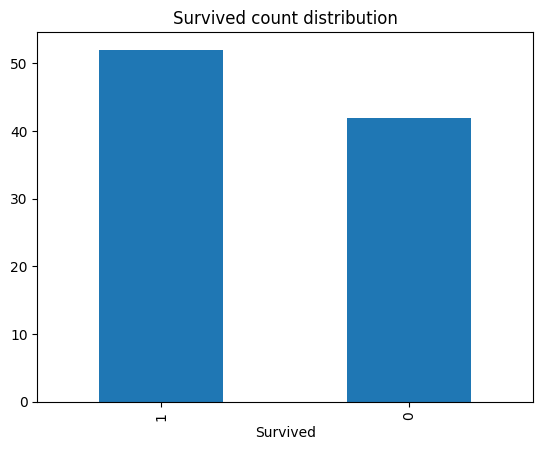

In [216]:
# Take a look at "Survived" in the training set to watch for any pronounced class imbalance
df__engineeredtrain["Survived"].value_counts().plot(kind="bar", title="Survived count distribution")

In [217]:
# Separate Covariates and Target in df__engineeredtrain
df__covariates = df__engineeredtrain[df__engineeredtrain.columns[~(df__engineeredtrain.columns.isin(["Survived"]))]].copy(deep=True)
df__target = df__engineeredtrain[["Survived"]].copy(deep=True).astype(int)

# Cleanup
del df__engineeredtrain

In [218]:
# Perform an encoding of all categorical covariates modalities for both df__covariates and df__engineeredtest

# Initialize a counter
int__counter = 0

# Create a copy of df__covariates
df__nwcovariates = df__covariates.copy(deep=True)

# Create a copy of df__engineeredtest
df__nwengineeredtest = df__engineeredtest.copy(deep=True)

# Define a list with all the names of covariates 
list__covariates = df__covariates[df__covariates.columns[~(df__covariates.columns.isin(["SimilarPassengerIds", "GroupSize"]))]]

# Go through each feature
for str__featurename in list__covariates:
    
    # Initialize a OneHotEncoder object
    onehotencoder__object = OneHotEncoder(drop="first", sparse_output=False)

    # Fit onehotencoder__object to str__featurename modalities in df__covariates
    onehotencoder__object.fit(df__covariates[[str__featurename]])
    
    # Perform an encoding of str__featurename modalities in df__covariates
    array__feature = onehotencoder__object.transform(df__covariates[[str__featurename]])
    # Convert array__feature into a DataFrame
    df__feature = pd.DataFrame(data=array__feature, columns=[str__featurename + "_newfeature" + str(int__i) for int__i in range(int__counter, array__feature.shape[1]+int__counter)])
    # Add df__feature into df__nwcovariates
    df__nwcovariates = pd.concat([df__nwcovariates, df__feature], axis=1)
    # Cleanup
    del df__nwcovariates[str__featurename], array__feature, df__feature

    # Perform an encoding of str__featurename modalities in df__nwengineeredtest
    array__feature = onehotencoder__object.transform(df__nwengineeredtest[[str__featurename]])
    # Convert array__feature into a DataFrame
    df__feature = pd.DataFrame(data=array__feature, columns=[str__featurename + "_newfeature" + str(int__i) for int__i in range(int__counter, array__feature.shape[1]+int__counter)])
    # Add df__feature into df__nwengineeredtest
    df__nwengineeredtest = pd.concat([df__nwengineeredtest, df__feature], axis=1)
    # Cleanup
    del df__nwengineeredtest[str__featurename], onehotencoder__object, df__feature

    # Increment int__counter
    int__counter += array__feature.shape[1]

    # Cleanup
    del array__feature

# Cleanup
del str__featurename, int__counter, list__covariates

##### *7.1. Try a logistic regression*

In [219]:
# Put back together the data that will be used to train a logistic regression model
df__logisticregression = pd.concat([df__nwcovariates, df__target], axis=1)
list__logregcovariates = df__nwcovariates.columns[~(df__nwcovariates.columns.isin(["Survived", "SimilarPassengerIds"]))]

In [220]:
# Remove any eventual duplicate infos
df__logisticregression.drop_duplicates(inplace=True)

# Reset index values
df__logisticregression.reset_index(inplace=True, drop=True)

# Make sure the rank of matrix of covariates is no less than the min number of samples and covariates
print(f"The minimum number of samples and covariates of the covariates matrix is {min(df__logisticregression[list__logregcovariates].shape)}.")
print(f"The rank of the covariates matrix is {np.linalg.matrix_rank(df__logisticregression[list__logregcovariates])}.")

The minimum number of samples and covariates of the covariates matrix is 7.
The rank of the covariates matrix is 7.


In [221]:
# Initialize two LogisticRegression objects : be careful of your chosen parameters
logisticregression__object1 = LogisticRegression(random_state=123, penalty="l2", C=1, max_iter=100, solver="lbfgs")
logisticregression__object2 = LogisticRegression(random_state=123, penalty="l2", C=1, max_iter=100, solver="lbfgs")

In [222]:
# Fit logisticregression__object1 to all covariates
logisticregression__object1.fit(
    X=np.array(df__logisticregression[list__logregcovariates])
    , y=np.array(df__logisticregression["Survived"]))

# Check the number of iterations used for the optimization algo to converge (if it converges)
logisticregression__object1.n_iter_

array([8], dtype=int32)

In [223]:
# Fit logisticregression__object2 only to relevant covariates
# By irrelevant covariates, we're talking about discarding those which have statistically the weakest associations with "Survived"
# Covariates with the weakest associations with "Survived" were noticed in the previous section 6.

list__logregrelevantcovariates = [str__covariate for str__covariate in list__logregcovariates if "AgeCategory" not in str__covariate and "FamilySize" not in str__covariate]

logisticregression__object2.fit(
    X=np.array(df__logisticregression[list__logregrelevantcovariates])
    , y=np.array(df__logisticregression["Survived"]))

# Check the number of iterations used for the optimization algo to converge (if it converges)
logisticregression__object2.n_iter_

array([8], dtype=int32)

In [224]:
# Get predicted death probabilities coming from each model
df__logisticregression = pd.concat(
    [
        df__logisticregression
        , pd.DataFrame(data=np.array(pd.DataFrame(logisticregression__object1.predict_proba(X=np.array(df__logisticregression[list__logregcovariates]))).loc[:, 0]), columns=["DeathProbability_model1"])
        , pd.DataFrame(data=np.array(pd.DataFrame(logisticregression__object2.predict_proba(X=np.array(df__logisticregression[list__logregrelevantcovariates]))).loc[:, 0]), columns=["DeathProbability_model2"])  
    ]
    , axis=1)

In [225]:
# Display characteristics of predicted death probabilities by model1 for each "Survived" modality 
df__logisticregression[["DeathProbability_model1", "Survived"]].groupby(["Survived"], observed=False).describe()

DeathProbability_model1                                          \
                           count      mean       std       min       25%   
Survived                                                                   
0                           42.0  0.482991  0.102763  0.286366  0.415011   
1                           52.0  0.417556  0.117985  0.222189  0.322586   

                                        
               50%       75%       max  
Survived                                
0         0.476427  0.555592  0.684354  
1         0.415284  0.504254  0.684354

-  50% of groups who survived have their death probabilities lesser than or equal to 0.42, and 50% of death groups have their death probabilities equal or higher than 0.48.

-  75% of people who survived have their death probabilities lesser than or equal to approximately 0.5, and only 25% of dead people have their death probabilities equal or higher than 0.56.

-  The max death probability observed in both groups of survived or dead people is the same : 68.44%.

In [226]:
# Display characteristics of predicted death probabilities by model2 for each "Survived" modality 
df__logisticregression[["DeathProbability_model2", "Survived"]].groupby(["Survived"], observed=False).describe()

DeathProbability_model2                                          \
                           count      mean       std       min       25%   
Survived                                                                   
0                           42.0  0.480702  0.101720  0.291706  0.411615   
1                           52.0  0.419452  0.112846  0.257296  0.331274   

                                       
               50%       75%      max  
Survived                               
0         0.475248  0.559759  0.64613  
1         0.411615  0.476710  0.64613

-  50% of groups who survived have their death probabilities lesser than or equal to 0.41, and 50% of death groups have their death probabilities equal or higher than 0.48.

-  75% of groups who survived have their death probabilities lesser than or equal to approximatel 0.48, and 25% of death groups have their death probabilities equal or higher than 0.56.

-  The max death probability observed in both groups of survived or dead people is the same : 64.61%.

- Similar results are obtained from both models, and since this second model uses less features than the first we'll keep this one and discard the first when proceeding further.

In [227]:
# Clean up
list__logregcovariates = list__logregrelevantcovariates
del logisticregression__object1, df__logisticregression["DeathProbability_model1"], list__logregrelevantcovariates

In [228]:
# Look for the best threshold so we can have a good prediction on all passengers in the training set : work on the size of each group of similar passengers

# Prepare the data used to search for an adequate threshold
df__table = df__logisticregression[["DeathProbability_model2", "Survived", "SimilarPassengerIds"]].copy(deep=True)
df__table["GroupSize"] = df__table["SimilarPassengerIds"].apply(lambda x: len(x.split("__")))
df__table["GroupWeight"] = df__table["GroupSize"] / df__table["GroupSize"].sum()

# Define the objective function according to the current problem
def function__objective1(float__threshold: float, array__deathprobabilities: np.ndarray, array__groupweights: np.ndarray, array__survived: np.ndarray)-> float:
    """
    Input:
    float__threshold : a float (value which helps identifies if a passenger death probability is enough high to be considered as a dead person)
    array__deathprobabilities : an array of float (array of death probabilities for each group of passengers)
    array__groupweights : an array of float (array of weigths for each group of passengers)
    array__survived : an array of integer (with only 0 or 1) which is the survival state of each group of passengers
    
    Output:
    float__sumerrors : a float (sum of squared differences between actual survival outcomes and weighted predicted survival probabilities for each passenger group) 
    """
    
    float__sumerrors = np.sum((((array__deathprobabilities > float__threshold).astype(int)) * array__groupweights - array__survived) ** 2)
    return float__sumerrors

# Do the optimization
optimizeresult__object = minimize(
    fun=lambda x: function__objective1(
        float__threshold=x[0]
        , array__deathprobabilities=np.array(df__table["DeathProbability_model2"])
        , array__groupweights=np.array(df__table["GroupWeight"])
        , array__survived=np.array(df__table["Survived"]))
    , x0=[0.5]  # Initial guess for float__threshold
    , bounds=[(0, 1)] # float__threshold must be between 0 and 1
    , method='L-BFGS-B'
    , options={'ftol': 1e-9, 'maxiter': 1000} # stopping criteria for the algo to stop if an optimum is not found / is found
)

# Analyze if an optimum was found
print(optimizeresult__object)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 51.866093280982916
        x: [ 5.000e-01]
      nit: 0
      jac: [ 0.000e+00]
     nfev: 2
     njev: 1
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>


In [229]:
# Get the optimal threshold
float__optimthreshold = optimizeresult__object.x[0]

# Predict "Survived"
df__table["SurvivedPredicted"] = df__table["DeathProbability_model2"].apply(lambda x: 1 if x <= float__optimthreshold else 0)

# Compute the total number of good prediction
print("_________ \n")
print(f"Out of {df__table[df__table["Survived"] == 0]["GroupSize"].sum()} passengers who did not survived, we were able to predict correctly {df__table[(df__table["Survived"] == df__table["SurvivedPredicted"]) & (df__table["Survived"] == 0)]["GroupSize"].sum()}.")
print("_________ \n")
print(f"Out of {df__table[df__table["Survived"] == 1]["GroupSize"].sum()} passengers who survived, we were able to predict correctly {df__table[(df__table["Survived"] == df__table["SurvivedPredicted"]) & (df__table["Survived"] == 1)]["GroupSize"].sum()}.")
print("_________ \n")
print(f"Globally, out of {df__table["GroupSize"].sum()} passengers, we were able to predict correctly {df__table[(df__table["Survived"] == df__table["SurvivedPredicted"])]["GroupSize"].sum()}.")


_________ 

Out of 549 passengers who did not survived, we were able to predict correctly 353.
_________ 

Out of 342 passengers who survived, we were able to predict correctly 267.
_________ 

Globally, out of 891 passengers, we were able to predict correctly 620.


In [230]:
# Try to understand bad predictions on some passengers : we try to relate bad predictions to inaccurate/missing data

# Keep only bad predictions
df__nwtable = df__table[df__table["Survived"] != df__table["SurvivedPredicted"]][["SimilarPassengerIds"]].copy(deep=True)

# Get list of all passengers with bad predictions
list__badpredictions = []
for str__passengersgroup in df__nwtable["SimilarPassengerIds"].tolist():
    list__passengersgroup = str__passengersgroup.split("__")
    list__badpredictions = list__badpredictions + list__passengersgroup
    # Cleanup
    del list__passengersgroup

# Cleanup
del str__passengersgroup

# Get how many of passengers with bad predictions have missing data
print(f"Out of {len(list__badpredictions)} passengers with bad predictions : \n")
print(f"{len([str__passengerid for str__passengerid in list__badpredictions if str__passengerid in list__missingage])} have missing and/or approximately estimated age. \n")
print(f"{len([str__passengerid for str__passengerid in list__badpredictions if str__passengerid in list__missingfare])} have missing fare. \n")
print(f"{len([str__passengerid for str__passengerid in list__badpredictions if str__passengerid in list__missingembarked])} have missing embarkation points. \n")

Out of 271 passengers with bad predictions : 

48 have missing and/or approximately estimated age. 

0 have missing fare. 

0 have missing embarkation points. 



In [231]:
# Try to understand bad predictions on some passengers : try to identify any common pattern between these passengers

# Update df__nwtable
df__nwtable = df__nwtable.merge(right=df__covariates, on=["SimilarPassengerIds"], how="inner")
del df__nwtable["SimilarPassengerIds"]

# Take a look at df__nwtable using a Multi-level cross-tabulation
pd.crosstab([df__nwtable[str__covariate] for str__covariate in df__nwtable.columns[:-1]], df__nwtable[df__nwtable.columns[-1]])

FamilySize                                         alone  not alone
Sex    Embarked BoardingClass         AgeCategory                  
female C        least privileged      adult            0          1
                                      young            1          1
                most privileged       adult            1          0
       Q        least privileged      adult            1          1
                                      young            1          1
       S        least privileged      adult            1          1
                                      young            1          1
                moderately privileged adult            1          1
                most privileged       adult            0          1
                                      young            0          1
male   C        least privileged      adult            1          0
                                      young            1          1
                moderately privileged adult            1          1
                most privileged       adult            1          1
                                      young            0          1
       Q        least privileged      adult            1          1
       S        least privileged      adult            1          1
                                      young            1          1
                moderately privileged adult            1          1
                                      young            1          1
                most privileged       adult            1          1
                                      young            0          1

_There seems to be **no obvious commonality** among misclassified cases._

<div style="background-color: green; padding: 10px;">

The logistic regression model based on covariates such as "Sex", "Embarked" and "BoardingClass", and a death probability threshold of 0.5 was able to give on the training set :
- An accuracy of 78.07% for the actual people who survived ;
- An accuracy of 64.3% for the actual people who did not survived ;
- Keeping in mind that proportions of survived and dead groups are similar in the training set, the overall accuracy is 69.58%.

We'll keep the logistic regression as a based model to which we'll compare some advanced models, since its result is better than a model where we choose to consider all people as dead or alive : an overall accuracy at least 7% higher, and at most 32% higher than this of a model where we consider all people as dead or alive.
</div>

In [232]:
# Cleanup
df__logisticregression.rename(columns={"DeathProbability_model2":"DeathProbability_logreg"}, inplace=True)
del optimizeresult__object, df__table, float__optimthreshold, list__badpredictions, df__nwtable

##### *7.2. Try a random forest*

Our goal when using a random forest is to use primarly a decision tree ability to take into account interactions between features. Secondly, a decision tree has the ability to do feature selection so only relevant features will be used. Thirdly, using the concept of bagging enables us to combine the predictive power of different decision trees for a better generalization.

In [233]:
# Put back together the data that will be used to train a random forest model
df__randomforest = pd.concat([df__nwcovariates, df__target], axis=1)
list__rfcovariates = df__randomforest.columns[~(df__randomforest.columns.isin(["Survived", "SimilarPassengerIds"]))].tolist()

# Remove any eventual duplicate infos
df__randomforest.drop_duplicates(inplace=True)

# Reset index values
df__randomforest.reset_index(inplace=True, drop=True)

# Make sure the rank of matrix of covariates is no less than the min number of samples and covariates
print(f"The minimum number of samples and covariates of the covariates matrix is {min(df__randomforest[list__rfcovariates].shape)}.")
print(f"The rank of the covariates matrix is {np.linalg.matrix_rank(df__randomforest[list__rfcovariates])}.")

The minimum number of samples and covariates of the covariates matrix is 7.
The rank of the covariates matrix is 7.


In [234]:
# Compute each group of passengers weight
df__randomforest["GroupSize"] = df__randomforest["SimilarPassengerIds"].apply(lambda x: len(x.split("__")))
df__randomforest["GroupWeight"] = df__randomforest["GroupSize"] / df__randomforest["GroupSize"].sum()

In [235]:
# Initialize a RandomForest object : be careful of your chosen parameters
randomforest__object = RandomForestClassifier(
    n_estimators=50
    , criterion="gini"
    , max_features=len(list__rfcovariates)
    , bootstrap=True # Use bootstraped samples when constructing any of n_estimators trees
    , random_state=123
    )

In [236]:
# Fit randomforest__object
randomforest__object.fit(
    X=np.array(df__randomforest[list__rfcovariates])
    , y=np.array(df__randomforest["Survived"])
    , sample_weight=np.array(df__randomforest["GroupWeight"])
)

RandomForestClassifier(max_features=7, n_estimators=50, random_state=123)

In [237]:
# Get the predicted death probabilities given by the model
df__randomforest = pd.concat(
    [
        df__randomforest
        , pd.DataFrame(data=np.array(pd.DataFrame(randomforest__object.predict_proba(X=np.array(df__randomforest[list__rfcovariates]))).loc[:, 0]), columns=["DeathProbability_rf"])
    ]
    , axis=1)

In [238]:
# Display characteristics of predicted death probabilities for each "Survived" modality 
df__randomforest[["DeathProbability_rf", "Survived"]].groupby(["Survived"], observed=False).describe()

DeathProbability_rf                                          \
                       count      mean       std       min       25%   
Survived                                                               
0                       42.0  0.580082  0.185246  0.172402  0.486788   
1                       52.0  0.397209  0.252922  0.012000  0.097537   

                                        
               50%       75%       max  
Survived                                
0         0.576104  0.729542  0.928926  
1         0.483238  0.593685  0.773447

-  50% of groups who survived have their death probabilities lesser than or equal to 0.48, and 50% of death groups have their death probabilities equal or higher than 0.58.

- 75% of groups who survived have their death probabilities lesser than or equal to 0.59, and 25% of death people have their death probabilities equal or higher than 0.73.

-  The max death probability observed for death groups is up to 0.77; whereas for groups who are alive, their max death probability is up to 0.93.

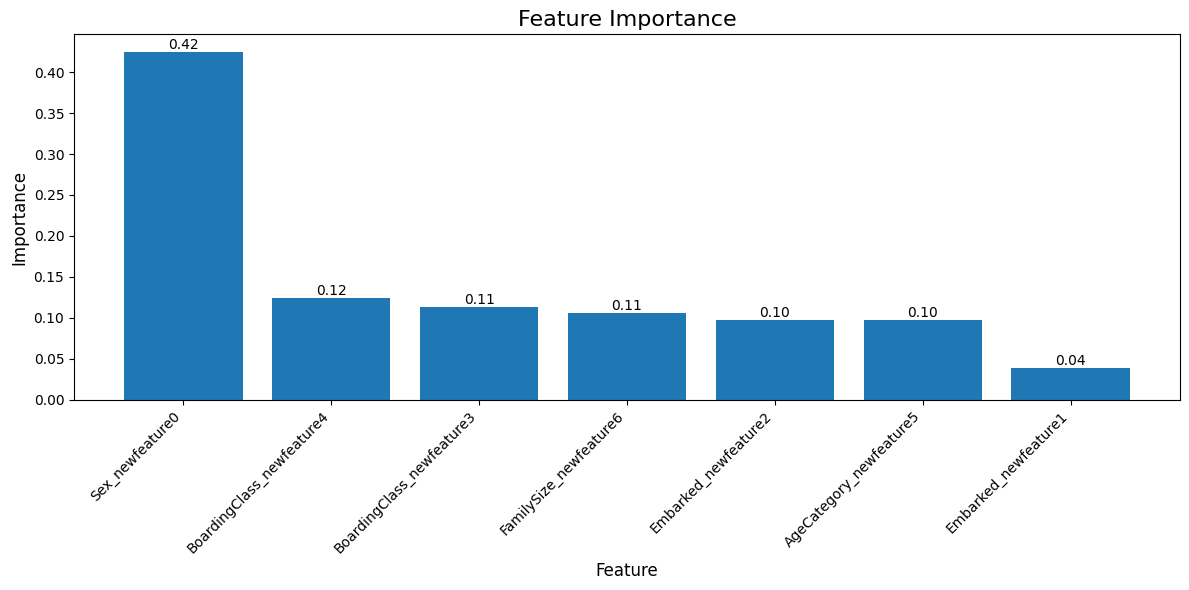

In [239]:
# Get a look at each feature importance

# Prepare data for plotting
df__table = pd.DataFrame(data=randomforest__object.feature_importances_, columns=["FeatureImportance"])
df__table = pd.concat([df__table, pd.DataFrame(data=list__rfcovariates, columns=["Feature"])], axis=1)
df__table = df__table.sort_values(by=["FeatureImportance"], ascending=False).reset_index()

# Define the plot
plt.figure(figsize=(12, 6))
barcontainer__object = plt.bar(df__table["Feature"], df__table["FeatureImportance"])

# Customize the plot
plt.title("Feature Importance", fontsize=16)
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Importance", fontsize=12)
plt.xticks(rotation=45, ha="right")

# Add value labels on top of each bar of the plot
for rectangle__bar in barcontainer__object:
    float__height = rectangle__bar.get_height()
    plt.text(
        rectangle__bar.get_x() + rectangle__bar.get_width()/2., float__height
        , f'{float__height:.2f}', ha="center", va="bottom")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

The "Sex covariate exhibits the highest discriminative power among all predictors in differentiating survival outcomes.

In [240]:
# Cleanup
del df__table, barcontainer__object, rectangle__bar, float__height

In [241]:
# Look for the best threshold so we can have a good prediction on all passengers in the training set : work on the size of each group of similar passengers

# Prepare the data used to search for an adequate threshold
df__table = df__randomforest[["DeathProbability_rf", "Survived", "SimilarPassengerIds", "GroupSize", "GroupWeight"]].copy(deep=True)

# Define the objective function according to the current problem
def function__objective2(float__threshold: float, array__deathprobabilities: np.ndarray, array__groupweights: np.ndarray, array__survived: np.ndarray)-> float:
    """
    Input:
    float__threshold : a float (value which helps identifies if a passenger death probability is enough high to be considered as a dead person)
    array__deathprobabilities : an array of float (array of death probabilities for each group of passengers)
    array__groupweights : an array of float (array of weigths for each group of passengers)
    array__survived : an array of integer (with only 0 or 1) which is the survival state of each group of passengers
    
    Output:
    float__sumerrors : a float (sum of squared differences between actual survival outcomes and weighted predicted survival probabilities for each passenger group) 
    """
    
    float__sumerrors = np.sum((((array__deathprobabilities > float__threshold).astype(int)) * array__groupweights - array__survived) ** 2)
    return float__sumerrors

# Do the optimization
optimizeresult__object = minimize(
    fun=lambda x: function__objective2(
        float__threshold=x[0]
        , array__deathprobabilities=np.array(df__table["DeathProbability_rf"])
        , array__groupweights=np.array(df__table["GroupWeight"])
        , array__survived=np.array(df__table["Survived"]))
    , x0=[0.5]  # Initial guess for float__threshold
    , bounds=[(0, 1)] # float__threshold must be between 0 and 1
    , method='L-BFGS-B'
    , options={'ftol': 1e-9, 'maxiter': 1000} # stopping criteria for the algo to stop if an optimum is not found / is found
)

# Analyze if an optimum was found
print(optimizeresult__object)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 51.74444406655405
        x: [ 5.000e-01]
      nit: 0
      jac: [ 0.000e+00]
     nfev: 2
     njev: 1
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>


In [242]:
# Get the optimal threshold
float__optimthreshold = optimizeresult__object.x[0]

# Predict Survived
df__table["SurvivedPredicted"] = df__table["DeathProbability_rf"].apply(lambda x: 1 if x <= float__optimthreshold else 0)

# Compute the total number of good prediction for all the passengers
print("_________ \n")
print(f"Out of {df__table[df__table["Survived"] == 0]["GroupSize"].sum()} passengers who did not survived, we were able to predict correctly {df__table[(df__table["Survived"] == df__table["SurvivedPredicted"]) & (df__table["Survived"] == 0)]["GroupSize"].sum()}.")
print("_________ \n")
print(f"Out of {df__table[df__table["Survived"] == 1]["GroupSize"].sum()} passengers who survived, we were able to predict correctly {df__table[(df__table["Survived"] == df__table["SurvivedPredicted"]) & (df__table["Survived"] == 1)]["GroupSize"].sum()}.")
print("_________ \n")
print(f"Globally, out of {df__table["GroupSize"].sum()} passengers, we were able to predict correctly {df__table[(df__table["Survived"] == df__table["SurvivedPredicted"])]["GroupSize"].sum()}.")


_________ 

Out of 549 passengers who did not survived, we were able to predict correctly 525.
_________ 

Out of 342 passengers who survived, we were able to predict correctly 210.
_________ 

Globally, out of 891 passengers, we were able to predict correctly 735.


In [243]:
# Try to understand bad predictions on some passengers : we try to relate bad predictions to inaccurate/missing data

# Keep only bad predictions
df__nwtable = df__table[df__table["Survived"] != df__table["SurvivedPredicted"]][["SimilarPassengerIds"]].copy(deep=True)

# Get list of all passengers with bad predictions
list__badpredictions = []
for str__passengersgroup in df__nwtable["SimilarPassengerIds"].tolist():
    list__passengersgroup = str__passengersgroup.split("__")
    list__badpredictions = list__badpredictions + list__passengersgroup
    # Cleanup
    del list__passengersgroup

# Cleanup
del str__passengersgroup

# Get how many of passengers with bad predictions have missing data
print(f"Out of {len(list__badpredictions)} passengers with bad predictions : \n")
print(f"{len([str__passengerid for str__passengerid in list__badpredictions if str__passengerid in list__missingage])} have missing and/or approximately estimated age. \n")
print(f"{len([str__passengerid for str__passengerid in list__badpredictions if str__passengerid in list__missingfare])} have missing fare. \n")
print(f"{len([str__passengerid for str__passengerid in list__badpredictions if str__passengerid in list__missingembarked])} have missing embarkation points. \n")

Out of 156 passengers with bad predictions : 

26 have missing and/or approximately estimated age. 

0 have missing fare. 

0 have missing embarkation points. 



In [244]:
# Try to understand bad predictions on some passengers : try to identify any common pattern between these passengers

# Update df__nwtable
df__nwtable = df__nwtable.merge(right=df__covariates, on=["SimilarPassengerIds"], how="inner")
del df__nwtable["SimilarPassengerIds"]

# Take a look at df__nwtable using a Multi-level cross-tabulation
pd.crosstab([df__nwtable[str__covariate] for str__covariate in df__nwtable.columns[:-1]], df__nwtable[df__nwtable.columns[-1]])

FamilySize                                         alone  not alone
Sex    Embarked BoardingClass         AgeCategory                  
female C        least privileged      adult            0          1
                                      young            1          1
                most privileged       adult            1          0
       Q        least privileged      adult            1          1
                                      young            1          1
       S        least privileged      adult            1          1
                                      young            1          1
                moderately privileged adult            1          1
                most privileged       adult            0          1
                                      young            0          1
male   C        least privileged      adult            1          0
                                      young            1          1
                moderately privileged adult            1          0
                most privileged       adult            1          1
                                      young            0          1
       Q        least privileged      adult            1          1
       S        least privileged      adult            1          1
                                      young            1          1
                moderately privileged adult            1          1
                                      young            1          1
                most privileged       adult            1          1
                                      young            0          1

_There seems to be **no obvious commonality** among misclassified cases._

<div style="background-color: green; padding: 10px;">

The random forest model based on all covariates, and a death probability threshold of 0.5 was able to give on the training set :
- An accuracy of 61.4%  for the actual people who survived (lesser than 78.07% obtained by the logistic regression);
- An accuracy of 95.63% for the actual people who did not survived (higher than 64.3% obtained by the logistic regression);
- Keeping in mind that proportions of survived and dead groups are similar in the training set, the overall accuracy is 82.49% (at least 12% higher than the 69.58% of the logistic regression).

The logistic regression did well on the actual people who survived; and the actual dead people were well identified by the random forest. The final step we will try, will be a combination of the logistic regression and random forest results.
</div>

In [245]:
# Cleanup
del df__nwtable, df__table, float__optimthreshold, list__badpredictions

##### *7.3. Try a combination of logistic regression and random forest*

We try to resolve here an optimization problem where we want an **adequate threshold** and the **best linear combination of death probabilities issued by both logistic regression and random forest** for each group of passengers in the training set. 

Do not forget that each group size will be taken into account in the formulation of the optimization problem.

In [246]:
# Prepare data
df__mixedmodel = df__randomforest.merge(
    right=df__logisticregression[["SimilarPassengerIds", "DeathProbability_logreg"]]
    , on=["SimilarPassengerIds"], how="inner").copy(deep=True)

# Cleanup
del df__randomforest, df__logisticregression

In [247]:
# Take a look at df__mixedmodel
df__mixedmodel.sample(n=3)

,SimilarPassengerIds,Sex_newfeature0,Embarked_newfeature1,Embarked_newfeature2,BoardingClass_newfeature3,BoardingClass_newfeature4,AgeCategory_newfeature5,FamilySize_newfeature6,Survived,GroupSize,GroupWeight,DeathProbability_rf,DeathProbability_logreg
39,98__371__454__485__588__600__646__680,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1,8,0.008979,0.533105,0.473786
92,781__876,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,2,0.002245,0.481333,0.367728
18,20__368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2,0.002245,0.248333,0.367728


In [248]:
# Define the objective function according to the current problem
def function__objective3(
        float__threshold: float, array__deathprobabilitiesRF: np.ndarray, array__deathprobabilitiesLOGREG: np.ndarray
        , float__weightRF: float, float__weightLOGREG: float, float__lagrangemultiplier: float
        , array__groupweights: np.ndarray, array__survived: np.ndarray)-> float:
    """
    Input:
    float__threshold : a float (value which helps identifies if a passenger death probability is enough high to be considered as a dead person)
    array__deathprobabilitiesRF : an array of float (array of death probabilities for each group of passengers) issued by the random forest model
    array__deathprobabilitiesLOGREG : an array of float (array of death probabilities for each group of passengers) issued by the logistic regression model
    float__weightRF : a float (value which is the appropriate weight given to array__deathprobabilitesRF in the computation of the final death probabilities)
    float__weightLOGREG : a float (value which is the appropriate weight given to array__deathprobabilitesLOGREG in the computation of the final death probabilities)
    float__lagrangemultiplier :  a float (lagange multiplier value)
    array__groupweights : an array of float (array of weigths for each group of passengers)
    array__survived : an array of integer (with only 0 or 1) which is the survival state of each group of passengers
    
    Output:
    float__error : a float 
    (sum of squared differences between actual survival outcomes and weighted predicted survival probabilities for each passenger group, to which
    is added a Lagrangian penalty term)
    """

    # Compute the weighted average of death probabilities
    array__avgdeathprobabilites = float__weightRF*array__deathprobabilitiesRF + float__weightLOGREG*array__deathprobabilitiesLOGREG

    # Compute survival state predictions
    array__predictions = (array__avgdeathprobabilites > float__threshold).astype(int)
    array__weightedpredictions = array__groupweights * array__predictions

    # Compute the Lagrangian penalty term
    float__penalty = float__lagrangemultiplier * ((float__weightRF + float__weightLOGREG - 1) ** 2)

    # Compute error (objective function value)
    float__error = np.sum((array__weightedpredictions - array__survived) ** 2) + float__penalty

    return float__error

# Do the optimization
optimizeresult__object = minimize(
    fun=lambda x: function__objective3(
        float__threshold=x[0]
        , array__deathprobabilitiesRF=np.array(df__mixedmodel["DeathProbability_rf"])
        , array__deathprobabilitiesLOGREG=np.array(df__mixedmodel["DeathProbability_logreg"])
        , float__weightRF=x[1]
        , float__weightLOGREG=x[2]
        , float__lagrangemultiplier=0.5       
        , array__groupweights=np.array(df__mixedmodel["GroupWeight"])
        , array__survived=np.array(df__mixedmodel["Survived"]))
    , x0=[0.5, 0.5, 0.5]  # Initial guesses for float__threshold, float__weightRF and float__weightLOGREG
    , bounds=[(0, 1), (0, 1), (0, 1)] # float__threshold, float__weightRF and float__weightLOGREG must be between 0 and 1
    , method='L-BFGS-B'
    , options={'ftol': 1e-9, 'maxiter': 1000} # stopping criteria for the algo to stop if an optimum is not found / is found
)

# Analyze if an optimum was found
print(optimizeresult__object)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 51.80419735451535
        x: [ 5.000e-01  5.000e-01  5.000e-01]
      nit: 0
      jac: [ 0.000e+00  0.000e+00  0.000e+00]
     nfev: 4
     njev: 1
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


In [249]:
# Get the optimal threshold, and weights for random forest and logistic regression models
float__optimthreshold, float__rfweight, float__logregweight = optimizeresult__object.x[0], optimizeresult__object.x[1], optimizeresult__object.x[2]

# Predict Survived
df__mixedmodel["DeathProbability_mixedmodel"] = float__rfweight*df__mixedmodel["DeathProbability_rf"] + float__logregweight*df__mixedmodel["DeathProbability_logreg"]
df__mixedmodel["SurvivedPredicted"] = df__mixedmodel["DeathProbability_mixedmodel"].apply(lambda x: 1 if x <= float__optimthreshold else 0)

# Compute the total number of good prediction for all the passengers
print("_________ \n")
print(f"Out of {df__mixedmodel[df__mixedmodel["Survived"] == 0]["GroupSize"].sum()} passengers who did not survived, we were able to predict correctly {df__mixedmodel[(df__mixedmodel["Survived"] == df__mixedmodel["SurvivedPredicted"]) & (df__mixedmodel["Survived"] == 0)]["GroupSize"].sum()}.")
print("_________ \n")
print(f"Out of {df__mixedmodel[df__mixedmodel["Survived"] == 1]["GroupSize"].sum()} passengers who survived, we were able to predict correctly {df__mixedmodel[(df__mixedmodel["Survived"] == df__mixedmodel["SurvivedPredicted"]) & (df__mixedmodel["Survived"] == 1)]["GroupSize"].sum()}.")
print("_________ \n")
print(f"Globally, out of {df__mixedmodel["GroupSize"].sum()} passengers, we were able to predict correctly {df__mixedmodel[(df__mixedmodel["Survived"] == df__mixedmodel["SurvivedPredicted"])]["GroupSize"].sum()}.")

_________ 

Out of 549 passengers who did not survived, we were able to predict correctly 491.
_________ 

Out of 342 passengers who survived, we were able to predict correctly 237.
_________ 

Globally, out of 891 passengers, we were able to predict correctly 728.


In [250]:
# Display characteristics of predicted death probabilities for each "Survived" modality 
df__mixedmodel[["DeathProbability_mixedmodel", "Survived"]].groupby(["Survived"], observed=False).describe()

DeathProbability_mixedmodel                                          \
                               count      mean       std       min       25%   
Survived                                                                       
0                               42.0  0.530392  0.132607  0.233268  0.446734   
1                               52.0  0.408331  0.176035  0.134648  0.223029   

                                        
               50%       75%       max  
Survived                                
0         0.531208  0.637842  0.745210  
1         0.437920  0.547553  0.701455

-  50% of groups who survived have their death probabilities lesser than or equal to 0.44, and 50% of death groups have their death probabilities equal or higher than 0.53.

- 75% of groups who survived have their death probabilities lesser than or equal to 0.55, and 25% of death people have their death probabilities equal or higher than 0.64.

-  The max death probability observed for death groups is up to 0.74; whereas for groups who are alive, their max death probability is up to 0.7.

In [251]:
# Try to understand bad predictions on some passengers : we try to relate bad predictions to inaccurate/missing data

# Keep only bad predictions
df__table = df__mixedmodel[df__mixedmodel["Survived"] != df__mixedmodel["SurvivedPredicted"]][["SimilarPassengerIds"]].copy(deep=True)

# Get list of all passengers with bad predictions
list__badpredictions = []
for str__passengersgroup in df__table["SimilarPassengerIds"].tolist():
    list__passengersgroup = str__passengersgroup.split("__")
    list__badpredictions = list__badpredictions + list__passengersgroup
    # Cleanup
    del list__passengersgroup

# Cleanup
del str__passengersgroup

# Get how many of passengers with bad predictions have missing data
print(f"Out of {len(list__badpredictions)} passengers with bad predictions : \n")
print(f"{len([str__passengerid for str__passengerid in list__badpredictions if str__passengerid in list__missingage])} have missing and/or approximately estimated age. \n")
print(f"{len([str__passengerid for str__passengerid in list__badpredictions if str__passengerid in list__missingfare])} have missing fare. \n")
print(f"{len([str__passengerid for str__passengerid in list__badpredictions if str__passengerid in list__missingembarked])} have missing embarkation points. \n")

Out of 163 passengers with bad predictions : 

25 have missing and/or approximately estimated age. 

0 have missing fare. 

0 have missing embarkation points. 



In [252]:
# Try to understand bad predictions on some passengers : try to identify any common pattern between these passengers

# Update df__table
df__table = df__table.merge(right=df__covariates, on=["SimilarPassengerIds"], how="inner")
del df__table["SimilarPassengerIds"]

# Take a look at df__nwtable using a Multi-level cross-tabulation
pd.crosstab([df__table[str__covariate] for str__covariate in df__table.columns[:-1]], df__table[df__table.columns[-1]])

FamilySize                                         alone  not alone
Sex    Embarked BoardingClass         AgeCategory                  
female C        least privileged      adult            0          1
                                      young            1          1
                most privileged       adult            1          0
       Q        least privileged      adult            1          1
                                      young            1          1
       S        least privileged      adult            1          1
                                      young            1          1
                moderately privileged adult            1          1
                most privileged       adult            0          1
                                      young            0          1
male   C        least privileged      adult            1          0
                                      young            1          1
                moderately privileged adult            1          0
                most privileged       adult            1          1
                                      young            0          1
       Q        least privileged      adult            1          1
       S        least privileged      adult            1          1
                                      young            1          1
                moderately privileged adult            1          1
                                      young            1          1
                most privileged       adult            1          1
                                      young            0          1

_Still, there seems to be **no obvious commonality** among misclassified cases._

<div style="background-color: green; padding: 10px;">

The mix model, combining random forest (RF) and logistic regression (LR), demonstrated the following performance metrics on the training set:

1. Survival prediction accuracy:
   - mix model: 69.3%
   - RF: 61.4%
   - LR: 78.07%

2. Non-survival prediction accuracy:
   - mix model: 89.44%
   - RF: 95.63%
   - LR: 64.3%

3. Overall accuracy (balanced dataset):
   - mix model: 81.71%
   - RF: 82.49%
   - LR: 69.58%

The ensemble model tries to leverage strengths of both intial models: LR's performance in identifying survivors and RF's accuracy in detecting non-survivors.

_Limitations in model performance may be attributed to insufficient data granularity. Additional variables such as collision time, passenger locations at impact, ship flooding patterns, and emergency protocols could potentially enhance predictive accuracy._

Given the available Titanic data, the ensemble model's performance is deemed sufficient to predict passenger survival outcomes on the test set.

</div>

In [253]:
# Cleanup
del df__covariates, df__engineeredtest, df__mixedmodel, df__nwcovariates, df__table, df__target, df__test, df__train, list__badpredictions
del list__missingage, list__missingembarked, list__missingfare, optimizeresult__object

In [254]:
# Empty garbage collector
gc.collect()

3742

#### 8. Predict the target Survived for the test set

In [255]:
# Predict logistic regression death probabilities
df__nwengineeredtest["DeathProbability_logreg"] = np.array(pd.DataFrame(logisticregression__object2.predict_proba(X=np.array(df__nwengineeredtest[list__logregcovariates]))).loc[:, 0])

# Predict random forest death probabilities
df__nwengineeredtest["DeathProbability_rf"] = np.array(pd.DataFrame(randomforest__object.predict_proba(X=np.array(df__nwengineeredtest[list__rfcovariates]))).loc[:, 0])

# Computed the weight summ of both predicted death probabilities
df__nwengineeredtest["DeathProbability_mixedmodel"] = float__rfweight*df__nwengineeredtest["DeathProbability_rf"] + float__logregweight*df__nwengineeredtest["DeathProbability_logreg"]

# Compute the survival state
df__nwengineeredtest["Survived"] = df__nwengineeredtest["DeathProbability_mixedmodel"].apply(lambda x: 1 if x <= float__optimthreshold else 0)

# Save the result
df__nwengineeredtest[["PassengerId", "Survived"]].to_csv(path_or_buf=windowspath__data / "test" / "test_pred.csv", index=False)

In [256]:
# Cleanup
gc.collect()
%reset -f